# Title of Project

## Environment Set-up & Verification

In [1]:
import importlib
import sys

packages = [
    "python",
    "numpy",
    "scipy",
    "pandas",
    "matplotlib",
    "sklearn",
    "hyperspy",
    "ipywidgets",
    "seaborn",
    "tqdm"
]

print("Environment check")
print("=" * 50)
print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version.split()[0]}")
print("=" * 50)

for pkg in packages: 
    try:
        if pkg == "python":
            continue
        module = importlib.import_module(pkg)
        version = getattr(module, "__version__", "No__version__attribute")
        print(f"{pkg:15s} : {version}")
    except ImportError:
        print(f"{pkg:15s} : NOT INSTALLED")

# HyperSpy is the primary library for this project. Please explicitly confirm it's loading.

import hyperspy.api as hs
print("\nHyperSpy API successfully imported.")

Environment check
Python executable: C:\Users\elise\miniforge3\envs\zincsoap-ml\python.exe
Python version: 3.10.19
numpy           : 1.26.4
scipy           : 1.15.2
pandas          : 2.3.3
matplotlib      : 3.10.8
sklearn         : 1.7.2
hyperspy        : 2.4.0
ipywidgets      : 8.1.8
seaborn         : 0.13.2
tqdm            : 4.67.3

HyperSpy API successfully imported.


## Imports & project paths

In [2]:
from pathlib import Path
import os, gzip, shutil
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs

DATA = Path(r"./data_raw")
OUT = Path(r"./data_processed")
FIGS = Path(r"./figures")
OUT.mkdir(exist_ok=True)
FIGS.mkdir(exist_ok=True)

print("DATA:", DATA.resolve())
print("OUT:", OUT.resolve())
print("FIGS:", FIGS.resolve())

DATA: C:\Users\elise\OneDrive\Desktop\ZINCSOAP\data_raw
OUT: C:\Users\elise\OneDrive\Desktop\ZINCSOAP\data_processed
FIGS: C:\Users\elise\OneDrive\Desktop\ZINCSOAP\figures


## Extract .raw from .raw.gz

In [3]:
def gunzip_if_needed(gz_path: Path) -> Path: 
    raw_path = gz_path.with_suffix("")
    if raw_path.exists():
        print(f"[skip] {raw_path.name} already exists")
        return raw_path

    print(f"[do] Extracting {gz_path.name} -> {raw_path.name}")
    with gzip.open(gz_path, "rb") as f_in, open(raw_path, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

    return raw_path

aerial_gz = DATA / "Aerial 150x.raw.gz"
cs_gz = DATA / "CS 148x.raw.gz"

aerial_raw = gunzip_if_needed(aerial_gz)
cs_raw = gunzip_if_needed(cs_gz)

print("Done extracting.")

[skip] Aerial 150x.raw already exists
[skip] CS 148x.raw already exists
Done extracting.


## Load Aerial dataset & crop empty rows

In [24]:
aerial_rpl = DATA / "Aerial 150x.rpl"

sA = hs.load(aerial_rpl) # Consider cropping bottom pixels, empty
sA.set_signal_type("EDS_SEM")
print(type(sA))
print(sA)

<class 'exspy.signals.eds_sem.EDSSEMSpectrum'>
<EDSSEMSpectrum, title: , dimensions: (1024, 768|3093)>


## Set axes & EDS metadata
*Note: this is lifted directly from the authors' approach. It is possible to re-derive scales from the metadata, but this serves as a start.

In [25]:
# Spatial calibration
sA.axes_manager[0].name = "x"
sA.axes_manager[0].scale = 0.8451
sA.axes_manager[0].units = "µm"

sA.axes_manager[1].name = "y"
sA.axes_manager[1].scale = 0.8451
sA.axes_manager[1].units = "µm"

# Energy Calibration
sA.axes_manager[2].name = "Energy"
sA.axes_manager[2].offset = -0.955
sA.axes_manager[2].scale = 0.01
sA.axes_manager[2].units = "keV"

# EDS elements
sA.add_elements(["C","Cl","Zn","O","Cd","S"])

sA.metadata.General.title = "Aerial EDS Spectrum Image"

sA.axes_manager

Navigation axis name,size,index,offset,scale,units
x,1024,0,0.0,0.8451,µm
y,768,0,0.0,0.8451,µm
Signal axis name,size,,offset,scale,units
Energy,3093,,-0.955,0.01,keV


## Save to .hspy for faster reload

In [26]:
aerial_hspy = OUT / "Aerial 150x.hspy"
sA.save(aerial_hspy, overwrite=True)
print("Saved:", aerial_hspy)

Saved: data_processed\Aerial 150x.hspy


## Repeat for Cross-section

In [27]:
cs_rpl = DATA / "CS 148x.rpl"

sC = hs.load(cs_rpl) # Consider cropping bottom pixels, empty
sC.set_signal_type("EDS_SEM")
print(type(sC))
print(sC)

<class 'exspy.signals.eds_sem.EDSSEMSpectrum'>
<EDSSEMSpectrum, title: , dimensions: (1024, 768|3144)>


In [28]:
# Spatial calibration
sC.axes_manager[0].name = "x"
sC.axes_manager[0].scale = 0.859
sC.axes_manager[0].units = "µm"

sC.axes_manager[1].name = "y"
sC.axes_manager[1].scale = 0.8859
sC.axes_manager[1].units = "µm"

# Energy Calibration
sC.axes_manager[2].name = "Energy"
sC.axes_manager[2].offset = -0.955
sC.axes_manager[2].scale = 0.01
sC.axes_manager[2].units = "keV"

# EDS signal type + elements
sC.set_signal_type("EDS_SEM")
sC.add_elements(["C","Cl","Zn","O","Cd","S"])

sC.metadata.General.title = "Cross-section EDS Spectrum Image"

cs_hspy = OUT / "CS 148x.hspy"
sC.save(cs_hspy, overwrite=True)
print("Saved:", cs_hspy)

Saved: data_processed\CS 148x.hspy


## Preliminary Inspection

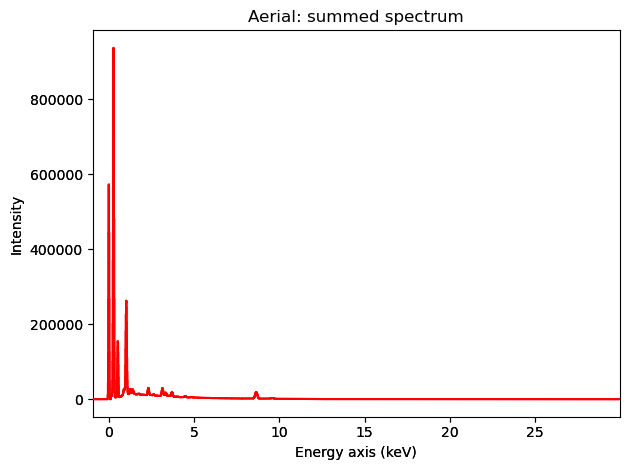

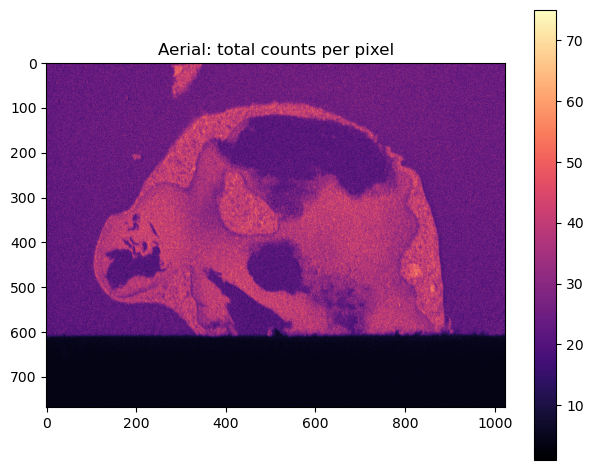

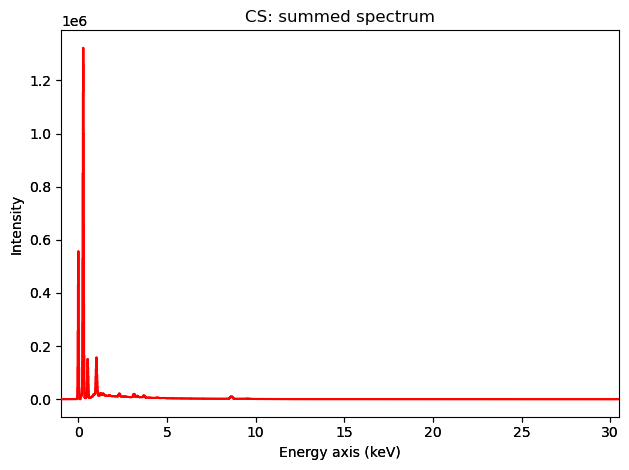

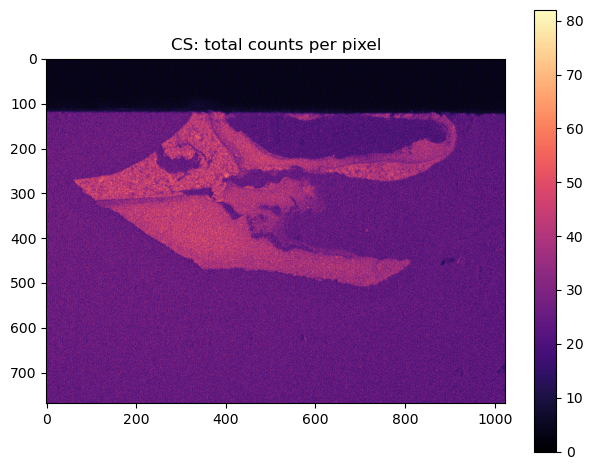

In [29]:
def quick_inspect(s, label):
    # Summed spectrum
    sum_spec = s.sum(axis=(0, 1))
    sum_spec.plot()
    plt.title(f"{label}: summed spectrum")
    plt.show()

    # Total counts per pixel (sum over energy)
    total_counts = s.sum(axis=2)
    plt.figure()
    plt.imshow(total_counts.data, cmap="magma")
    plt.title(f"{label}: total counts per pixel")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(FIGS / f"{label}_total_counts.png", dpi=300)
    plt.show()

quick_inspect(sA, "Aerial")
quick_inspect(sC, "CS")

## Simple preliminary preprocessing + one integrated elemental map (authors' Cl example)

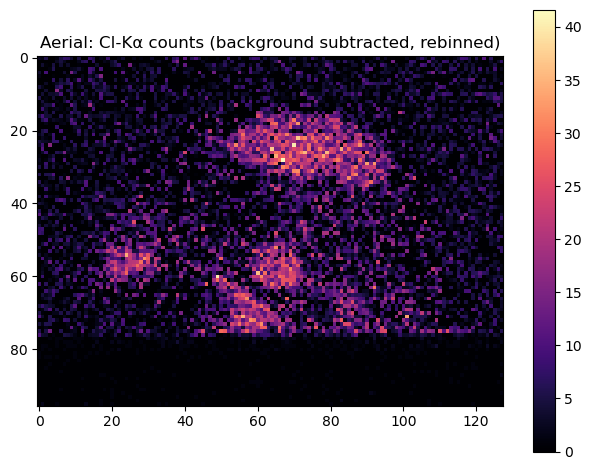

cl_ka shape: (96, 128)


In [32]:
# Authors' Cl background windows in keV
bkg_win_cl = np.array([
    [2.52, 2.56, 2.85, 2.92], # Cl_Ka background windows
    [2.52, 2.56, 2.85, 2.92], # Cl_Kb background windows
])

# Load the saved aerial.hspy and rebin like the authors
s = hs.load(aerial_hspy).isig[:-1].rebin(scale=(8,8,2))

cl_ka, cl_kb = s.get_lines_intensity(
    xray_lines=["Cl_Ka", "Cl_Kb"],
    background_windows=bkg_win_cl,
    plot_result=False
)

# Clean negative counts for display
cl_ka.data[cl_ka.data < 0] = 0

# Plot and save
plt.figure()
plt.imshow(cl_ka.data, cmap="magma")
plt.title("Aerial: Cl-Kα counts (background subtracted, rebinned)")
plt.colorbar()
plt.tight_layout()
plt.savefig(FIGS / "Aerial_Cl-Kalpha_counts.png", dpi=300)
plt.show()

print("cl_ka shape:", cl_ka.data.shape)